In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal

In [3]:
mpl.rcParams["figure.figsize"] = 10, 5

### DC Servo

$$J \ddot\theta + f \dot\theta = M_m$$

$$\frac{\theta(s)}{U(s)} = \frac{K}{s(1+\tau s)}$$

ZOH discretization with sampling time $h = 0.06$ s, gives discrete time transfer function:

$$H(z^{-1}) = \frac{0.004891z^{−1} + 0.004783z^{−2}}{(1 − z^{−1})(1 − 0.935507z^{−1})} = \frac{0.004891 z^{-1} +0.004783z^{-2}}{1-1.93551 z^{-1}+0.935507z^{-2}}$$

Thus, we have:

$$A(z^{-1}) = 1-1.93551 z^{-1}+0.935507z^{-2}$$

$$B(z^{-1}) = 0.004891 z^{-1} +0.004783z^{-2}$$

$a_1 = -1.93551$, $a_2 = 0.935507$, $b_0 = 0$, $b_1 = 0.004891$, $b_3 = 0.004783$.

\begin{equation}
    y(t) - 1.93551 y(t-1) + 0.935507 y(t-2) = 0.004891 u(t-1) + 0.004783 u(t-2)
\end{equation}
\begin{equation}
    y(t+1) - 1.93551 y(t) + 0.935507 y(t-1) = 0.004891 u(t) + 0.004783 u(t-1)
\end{equation}

Subtracting yields:

\begin{equation}
    (y(t+1) - y(t)) - 1.93551 (y(t) - y(t-1)) + 0.935507 (y(t-1) - y(t-2)) = 0.004891 \Delta u(t) + 0.004783 \Delta u(t-1)
\end{equation}

\begin{equation}
\begin{split}
    y(t+1) &= (1+1.93551)y(t) + (-1.93551 - 0.935507)y(t-1) + 0.935507 y(t-2) + 0.004891 \Delta u(t) + 0.004783 \Delta u(t-1) \\
    &= (a_0 - a_1)y(t) + (a_1 - a_2)y(t-1) + (a_2 - a_3)y(t-2) + b_0 \Delta u(t+1) + b_1 \Delta u(t) + b_2 \Delta u(t-1) \\
    &= 2.93551 y(t) -2.871017 y(t-1) + 0.935507 y(t-2) + 0.004891 \Delta u(t) + 0.004783 \Delta u(t-1)
\end{split}
\end{equation}


In [4]:
def genG(A, B, j):
    gfunc = lambda k : g[k] if 0 <= k < j else 0
    Afunc = lambda k : A[k] if 0 <= k < len(A) else 0
    Bfunc = lambda k : B[k] if 0 <= k < len(B) else 0
    
    g = [B[0]]
    for k in range(1,j):
        Aterm = -np.sum([Afunc(i)*gfunc(k-i) for i in range(1, k+1)])
        Bterm = np.sum([Bfunc(i) for i in range(k+1)])
        g.append(Aterm+Bterm)
        
    G = np.zeros((j,j))
    for i in range(j):
        G[i] = np.hstack([g[:i+1][::-1],np.zeros(j-(i+1))])
    
    return G

In [5]:
def genf(A, B, y, du, j):
    gfunc = lambda k : g[k] if 0 <= k < j else 0
    yfunc = lambda k : y[k] if 0 <= k < j else 0
    dufunc = lambda k : du[k] if 0 <= k < j else 0
    Afunc = lambda k : A[k] if 0 <= k < len(A) else 0
    Bfunc = lambda k : B[k] if 0 <= k < len(B) else 0
    
    y = list(np.copy(y))
    
    f = y
    Aterm = sum([(Afunc(i)-Afunc(i+1))*yi for i, yi in zip(range(len(A)), y[::-1][:len(A)])])
    Bterm = sum([bi*dui for bi, dui in zip(B[1:], du[::-1][:len(B[1:])])])
    
    y.append(Aterm + Bterm)
    f = [Aterm + Bterm]
    for k in range(j-1):
        Aterm = sum([(Afunc(i)-Afunc(i+1))*yi for i, yi in zip(range(len(A)), y[::-1][:len(A)])])
        y.append(Aterm)
        f.append(Aterm)
        
    return np.array(f).reshape((len(f), 1))

In [6]:
def gendu(G, f, w, l=0.8):
    if len(w) < len(f):
        w = np.hstack([w.flatten(), np.zeros(len(f)-len(w))])
        w = w.reshape((len(f), 1))
    else:
        w = w[:len(f)].reshape((len(f), 1))
        
#     H = 2*(G.dot(G.T) + l*np.eye(G.shape[0]))
#     print(np.linalg.pinv(G.dot(G.T) + l*np.eye(G.shape[0])).dot(G.T))
#     bT = 2*(f-w).T.dot(G)
#     f0 = (f-w).T.dot(f-w)
#     u = -np.linalg.pinv(H).dot(bT.T)
    u = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0])).dot(G.T).dot(w-f)
           
    return u

In [7]:
# Verification with 4.4
G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
f = genf(A=[1,-0.8],B=[0.4, 0.6],y=[0,0],du=[0],j=3)
w = np.ones((3,1))
du = gendu(G, f, w, l=0.8)
print("G =\n", G)
print()
print("f =\n", f)
print()
print("(G^T G + l I)^-1 G^T for l = 0.8 =\n")
print(np.linalg.pinv(G.T.dot(G) + 0.8*np.eye(G.shape[0])).dot(G.T))
print()
print("du =\n", du)

G =
 [[0.4   0.    0.   ]
 [1.32  0.4   0.   ]
 [2.056 1.32  0.4  ]]

f =
 [[0.]
 [0.]
 [0.]]

(G^T G + l I)^-1 G^T for l = 0.8 =

[[ 0.13339114  0.28591717  0.14710632]
 [-0.1542736  -0.16484019  0.28591717]
 [-0.02942126 -0.1542736   0.13339114]]

du =
 [[ 0.56641463]
 [-0.03319662]
 [-0.05030372]]


In [8]:
y = [0,0]
du = [0]
N = 50
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
# v = 1e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 1e-2*scipy.signal.square(4*np.arange(N),0.5)
v = np.zeros(N)

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=y,du=du,j=3)
    duk = gendu(G, f, w[k:], l=0.8)
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    y.append(yk0)
    du.append(duk0)

In [9]:
yC = [0,0]
duC = [0]
N = 50
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
# w = scipy.signal.square(0.4*np.arange(N),0.5)
# v = 1e-1*scipy.signal.square(2*np.arange(N),0.5)
l = 0.8
v = np.zeros(N)
alpha = -0.2*np.ones(N)
beta = 0.2*np.ones(N)

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=yC,du=duC,j=3)
    
    duk = gendu(G, f, w[k:], l=l)
        
    if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
        if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
            duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
    elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
        satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
        H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
        Hc = H[np.ix_(satidx,satidx)]
        a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
        a = a.reshape(a.shape[0], 1)
        dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
        dujstar = dujstar.reshape(dujstar.shape[0], 1)
        m = np.linalg.solve(Hc, a - dujstar)

        for i, i2 in enumerate(satidx):
            ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
            duk += H.dot(m[i]*ej)
                
    duk = np.clip(duk, alpha[k], beta[k])

    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    yC.append(yk0)
    duC.append(duk0)

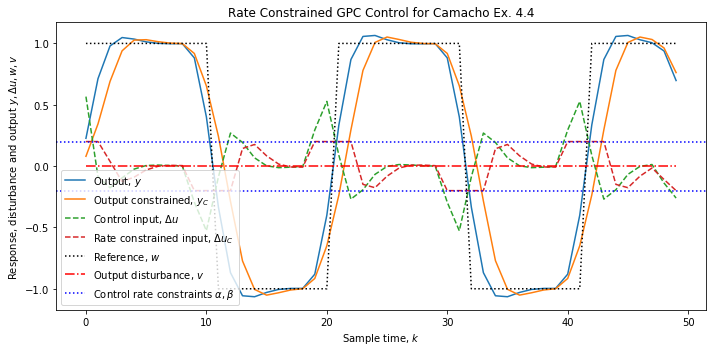

In [10]:
plt.plot(y[-N:], label=r"Output, $y$")
plt.plot(yC[-N:], label=r"Output constrained, $y_C$")

# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
plt.plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
plt.plot(duC[-N:], label=r"Rate constrained input, $\Delta u_C$", linestyle='--')
plt.plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
plt.plot(v[:N], label=r"Output disturbance, $v$", color='r', linestyle='-.')
plt.axhline(alpha[0], linestyle=':', color='b', label=r"Control rate constraints $\alpha, \beta$")
plt.axhline(beta[0], linestyle=':', color='b')
plt.xlabel(r"Sample time, $k$")
plt.ylabel(r"Response, disturbance and output $y, \Delta u, w, v$")
plt.title("Rate Constrained GPC Control for Camacho Ex. 4.4")
plt.legend()
plt.tight_layout()
# plt.savefig("RateConstrainedGPCPerturbed.pdf")
# plt.savefig("RateConstrainedGPC.pdf")

In [11]:
def phi0(lenA, lenB):
    phi0_y = np.zeros((lenA-1,1))
    phi0_u = np.zeros((lenB,1))
    return (np.vstack((phi0_y, phi0_u)), (lenA-1, lenB))

def P0(lenA, lenB, C=1e6):
    return C*np.eye(lenA-1+lenB)

def theta0(lenA, lenB):
    return np.zeros((lenA-1+lenB,1))

def update_phi(phi, part, y, u):
#     print(phi[part[1]-1:-1])
#     print(phi[0:part[0]-1])
    return np.vstack((-y, phi[1:part[0]-1], u, phi[part[0]:-1]))

def update_theta(thetaold, Pold, phi, y, alphat=1):
    L = (Pold.dot(phi))/(1/alphat + phi.T.dot(Pold.dot(phi)))
#     print("L", L)
#     print("Pold.dot(phi)", Pold.dot(phi))
#     print("theta old", thetaold)
#     print("phi", phi)
#     print("y", y)
#     print("thetaold.T.dot(phi)", thetaold.T.dot(phi))
    return thetaold + L.dot(y - thetaold.T.dot(phi))

def update_P(Pold, phi, alphat=1):
    return Pold - (Pold.dot(phi.dot(phi.T.dot(Pold))))/(1/alphat + phi.T.dot(Pold.dot(phi)))

### MSPI

In [12]:
jN = 3
y = list(np.zeros(jN-1))
yp = list(np.zeros(jN-1))
y1 = []
y2 = []
du = list(np.zeros(jN))
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
v = np.zeros(N)
# v2 = np.zeros(N)

A = [1,-0.8]
B = [0.4, 0.6]

lenA = len(A)
lenB = len(B)

phi, part = phi0(lenA,lenB)
P = P0(lenA,lenB)
theta = theta0(lenA,lenB)

phi2, part2 = phi0(lenA,lenB+1)
P2 = P0(lenA,lenB+1)
theta2 = theta0(lenA,lenB+1)

phi3, part3 = phi0(lenA,lenB+2)
P3 = P0(lenA,lenB+2)
theta3 = theta0(lenA,lenB+2)

alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

alpha = -0.5*np.ones(N)
beta = 0.5*np.ones(N)

for k in range(N):
    G = genG(A=A,B=B,j=jN)
    f = genf(A=A,B=B,y=y,du=du,j=jN)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
#     Aest = np.hstack(([1], theta2[:lenA-1].flatten()))
#     Best = theta2[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=jN)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=jN)
    
#     fest = np.vstack([yk0, yk1, yk2])
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    
    if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
        if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
            duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
    elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
        satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
        H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
        Hc = H[np.ix_(satidx,satidx)]
        a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
        a = a.reshape(a.shape[0], 1)
        dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
        dujstar = dujstar.reshape(dujstar.shape[0], 1)
        m = np.linalg.solve(Hc, a - dujstar)

        for i, i2 in enumerate(satidx):
            ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
            duk += H.dot(m[i]*ej)
                
    duk = np.clip(duk, alpha[k], beta[k])
    
    duk += v2[k] # probing signal
    duk0 = duk[0,0]
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    yk0p = theta.T.dot(np.vstack([-y[-1], du[-1], duk[0]]))[0,0]
    yk1 = theta.T.dot(np.vstack([-yk0, duk0, duk[1]]))[0,0]
    yk2 = theta2.T.dot(np.vstack([-yk0, duk0, duk[1], duk[2]]))[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    L2 = (P2.dot(phi2))/(1/alphat + phi2.T.dot(P2.dot(phi2)))
    L3 = (P3.dot(phi3))/(1/alphat + phi3.T.dot(P3.dot(phi3)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    theta2 = theta2 + L2.dot(yk0 - theta2.T.dot(phi2))
    theta3 = theta3 + L3.dot(yk0 - theta3.T.dot(phi3))
    
    P = P - L.dot(phi.T.dot(P))
    P2 = P2 - L2.dot(phi2.T.dot(P2))
    P3 = P3 - L3.dot(phi3.T.dot(P3))
    
    phi = update_phi(phi, part, yk0, duk0)
    phi2 = update_phi(phi2, part2, y[-1], duk0)
    phi3 = update_phi(phi3, part3, y[-2], duk0)
    
    y.append(yk0)
    yp.append(yk0p)
    y1.append(yk1)
    y2.append(yk2)
    du.append(duk0)

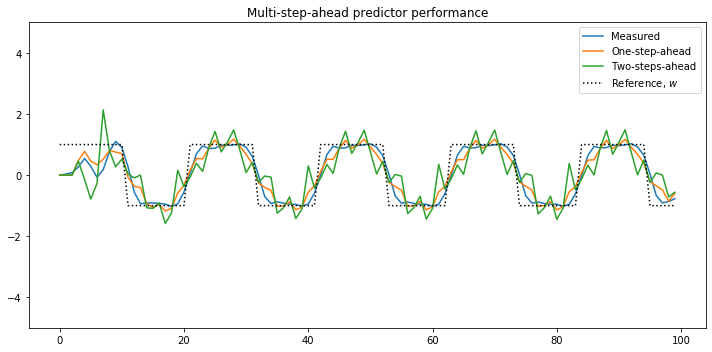

In [13]:
plt.title('Multi-step-ahead predictor performance')
plt.plot(y[-N:], label='Measured')
plt.plot((list(np.zeros(jN))+y1)[-N:], label='One-step-ahead')
plt.plot((list(np.zeros(jN+1))+y2)[-N:], label='Two-steps-ahead')
plt.plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
plt.ylim([-5,5])
plt.legend()
plt.tight_layout()
plt.savefig('MSPIPerformance.pdf')

### RCGPC STR

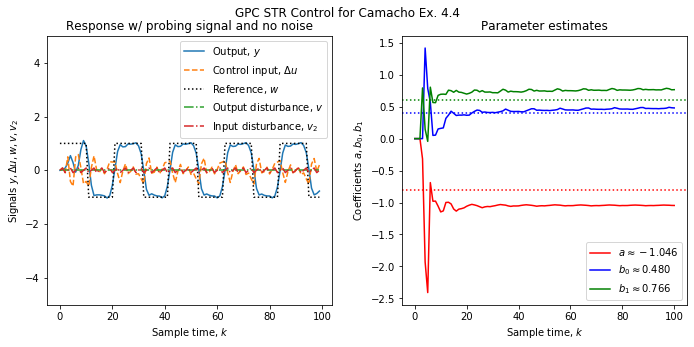

In [14]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')
# ax[0].plot(y1, label='One-step-ahead prediction')
# ax[0].plot(y2, label='Two-steps-ahead prediction')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/ probing signal and no noise")
ax[0].legend()

ax[0].set_ylim([-5,5])

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("GPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
# plt.savefig("GPCWithProbingNoNoise.pdf")

### GPC STR w/o noise/probing

In [15]:
y = [0,0]
du = [0]
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
# v = np.zeros(N)
v2 = np.zeros(N)

lenA = 2
lenB = 2

phi, part = phi0(2,2)
P = P0(2,2)
theta = theta0(2,2)
alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=y,du=du,j=3)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=3)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=3)
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    duk += v2[k] # probing signal
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    P = P - L.dot(phi.T.dot(P))
    
    phi = update_phi(phi, part, yk0, duk0)
    
    y.append(yk0)
    du.append(duk0)

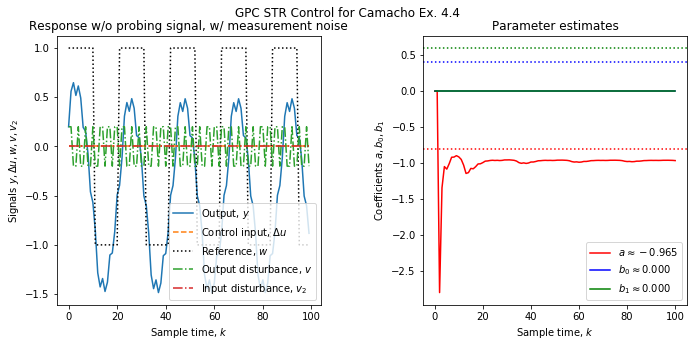

In [16]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/o probing signal, w/ measurement noise")
ax[0].legend()

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("GPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
plt.savefig("GPCNoProbingWithNoise.pdf")

### GPC STR w/ noise/probing

In [17]:
y = [0,0]
du = [0]
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
# v = np.zeros(N)
# v2 = np.zeros(N)

lenA = 2
lenB = 2

phi, part = phi0(2,2)
P = P0(2,2)
theta = theta0(2,2)
alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=y,du=du,j=3)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=3)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=3)
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    duk += v2[k] # probing signal
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    P = P - L.dot(phi.T.dot(P))
    
    phi = update_phi(phi, part, yk0, duk0)
    
    y.append(yk0)
    du.append(duk0)

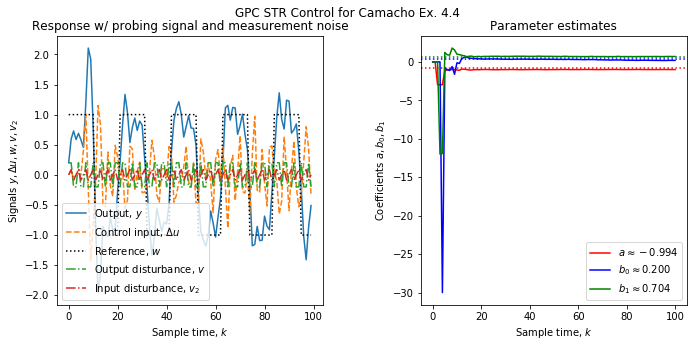

In [18]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/ probing signal and measurement noise")
ax[0].legend()

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("GPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
plt.savefig("GPCWithProbingWithNoise.pdf")

### RCGPC STR w/ probing

In [19]:
jN = 3
y = list(np.zeros(jN-1))
du = list(np.zeros(jN-2))
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
# v2 = np.random.normal(0, 5e-2, N)
v = np.zeros(N)
alpha = -0.5*np.ones(N)
beta = 0.5*np.ones(N)
# v2 = np.zeros(N)

# Afunc = lambda k : [1, -0.8 + 2e-3*k]
Afunc = lambda k : [1, -0.8]
# Bfunc = lambda k : [0.4 + 1e-3*k, 0.6 + 1e-3*k]
Bfunc = lambda k : [0.4, 0.6]

lenA = 2
lenB = 2

phi, part = phi0(lenA,lenB)
P = P0(lenA,lenB)
theta = theta0(lenA,lenB)
alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

for k in range(N):
    G = genG(A=Afunc(k),B=Bfunc(k),j=jN)
    f = genf(A=Afunc(k),B=Bfunc(k),y=y,du=du,j=jN)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=jN)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=jN)
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    
    if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
        if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
            duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
    elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
        satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
        H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
        Hc = H[np.ix_(satidx,satidx)]
        a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
        a = a.reshape(a.shape[0], 1)
        dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
        dujstar = dujstar.reshape(dujstar.shape[0], 1)
        m = np.linalg.solve(Hc, a - dujstar)

        for i, i2 in enumerate(satidx):
            ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
            duk += H.dot(m[i]*ej)
                
    duk = np.clip(duk, alpha[k], beta[k])
    
    duk += v2[k] # probing signal
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    P = P - L.dot(phi.T.dot(P))
    
    phi = update_phi(phi, part, yk0, duk0)
    
    y.append(yk0)
    du.append(duk0)

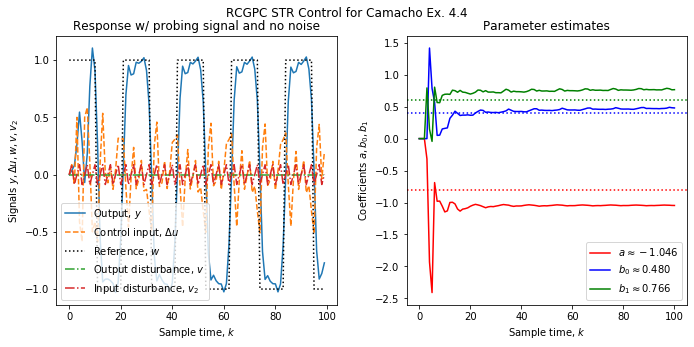

In [20]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/ probing signal and no noise")
ax[0].legend()

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(Afunc(np.arange(N))[1], linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(Bfunc(np.arange(N))[0], linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].plot(Bfunc(np.arange(N))[1], linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("RCGPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
plt.savefig("RCGPCProbingNoNoise.pdf")

### RCGPC STR w/ noise

In [21]:
y = [0,0]
du = [0]
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
# v = np.zeros(N)
v2 = np.zeros(N)

alpha = -0.5*np.ones(N)
beta = 0.5*np.ones(N)

lenA = 2
lenB = 2

phi, part = phi0(2,2)
P = P0(2,2)
theta = theta0(2,2)
alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=3)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=y,du=du,j=3)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=3)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=3)
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    
    if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
        if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
            duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
    elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
        satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
        H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
        Hc = H[np.ix_(satidx,satidx)]
        a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
        a = a.reshape(a.shape[0], 1)
        dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
        dujstar = dujstar.reshape(dujstar.shape[0], 1)
        m = np.linalg.solve(Hc, a - dujstar)

        for i, i2 in enumerate(satidx):
            ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
            duk += H.dot(m[i]*ej)
                
    duk = np.clip(duk, alpha[k], beta[k])
    
    duk += v2[k] # probing signal
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    P = P - L.dot(phi.T.dot(P))
    
    phi = update_phi(phi, part, yk0, duk0)
    
    y.append(yk0)
    du.append(duk0)

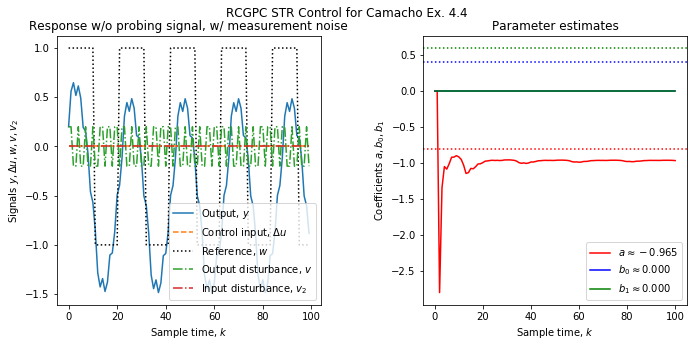

In [22]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/o probing signal, w/ measurement noise")
ax[0].legend()

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("RCGPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
plt.savefig("RCGPCNoProbingWithNoise.pdf")

### RCGPC STR w/ noise/probing

In [23]:
jN = 3
y = list(np.zeros(jN-1))
du = list(np.zeros(jN-2))
N = 100
# w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
w = scipy.signal.square(0.3*np.arange(N),0.5)
v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
# v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
# v = np.zeros(N)
# v2 = np.zeros(N)

alpha = -0.5*np.ones(N)
beta = 0.5*np.ones(N)

lenA = 2
lenB = 2

phi, part = phi0(lenA,lenB)
P = P0(lenA,lenB)
theta = theta0(lenA,lenB)
alphat = 1
theta_l = [theta]
# theta[0,0] = 1e-1
# theta[1,0] = 1e-1
# theta[2,0] = 1e-1

for k in range(N):
    G = genG(A=[1,-0.8],B=[0.4, 0.6],j=jN)
    f = genf(A=[1,-0.8],B=[0.4, 0.6],y=y,du=du,j=jN)
    
    Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    Best = theta[lenB-1:].flatten()
    
    Gest = genG(A=Aest,B=Best,j=jN)
    fest = genf(A=Aest,B=Best,y=y,du=du,j=jN)
    
    duk = gendu(Gest, fest, w[k:], l=0.8)
    
    if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
        if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
            duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
    elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
        satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
        H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
        Hc = H[np.ix_(satidx,satidx)]
        a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
        a = a.reshape(a.shape[0], 1)
        dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
        dujstar = dujstar.reshape(dujstar.shape[0], 1)
        m = np.linalg.solve(Hc, a - dujstar)

        for i, i2 in enumerate(satidx):
            ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
            duk += H.dot(m[i]*ej)
                
    duk = np.clip(duk, alpha[k], beta[k])
    
    duk += v2[k] # probing signal
    yk0 = (G.dot(duk)+f)[0,0] + v[k]
    duk0 = duk[0,0]
    
    L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
    
    theta = theta + L.dot(yk0 - theta.T.dot(phi))
    theta_l.append(theta)
    
    P = P - L.dot(phi.T.dot(P))
    
    phi = update_phi(phi, part, yk0, duk0)
    
    y.append(yk0)
    du.append(duk0)

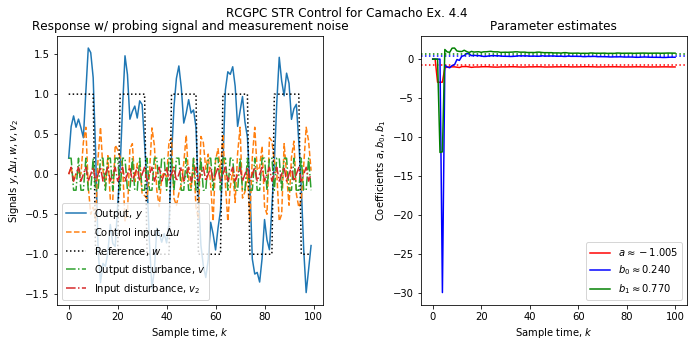

In [24]:
fig, ax = plt.subplots(1,2)

ax[0].plot(y[-N:], label=r"Output, $y$")
# plt.plot(y[-N:] - v[:N], label=r"Nominal output, $y-v$")
ax[0].plot(du[-N:], label=r"Control input, $\Delta u$", linestyle='--')
ax[0].plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
ax[0].plot(v[:N], label=r"Output disturbance, $v$", linestyle='-.')
ax[0].plot(v2[:N], label=r"Input disturbance, $v_2$", linestyle='-.')

ax[0].set_xlabel(r"Sample time, $k$")
ax[0].set_ylabel(r"Signals $y, \Delta u, w, v, v_2$")
ax[0].set_title("Response w/ probing signal and measurement noise")
ax[0].legend()

ax[1].plot(np.array(theta_l)[:,0], color='r', label=r"$a \approx "+f"{theta_l[-1][0][0]:.3f}"+"$")
ax[1].axhline(-0.8, linestyle=':', color='r')
ax[1].plot(np.array(theta_l)[:,2], color='b', label=r"$b_0 \approx "+f"{theta_l[-1][2][0]:.3f}"+"$")
ax[1].axhline(0.4, linestyle=':', color='b')
ax[1].plot(np.array(theta_l)[:,1], color='g', label=r"$b_1 \approx "+f"{theta_l[-1][1][0]:.3f}"+"$")
ax[1].axhline(0.6, linestyle=':', color='g')
ax[1].set_xlabel(r"Sample time, $k$")
ax[1].set_ylabel(r"Coefficients $a, b_0, b_1$")
ax[1].legend()
ax[1].set_title("Parameter estimates")

plt.suptitle("RCGPC STR Control for Camacho Ex. 4.4", y=0.98)

plt.tight_layout(2)
plt.savefig("RCGPCWithProbingWithNoise.pdf")

In [25]:
for MSPI_win in range (1,4):

    jN = 3
    y = list(np.zeros(jN-1))
    yp = list(np.zeros(jN-1))
    y1 = []
    y2 = []
    du = list(np.zeros(jN))
    N = 100
    # w = np.array([np.sin(4*np.pi*(k/N)) for k in range(N)])
    w = scipy.signal.square(0.3*np.arange(N),0.5) + scipy.signal.square(0.1*np.arange(N),0.5) - scipy.signal.square(.6*np.arange(N),0.5)
    v = 2e-1*scipy.signal.square(2*np.arange(N),0.5)
    # v2 = 2e-2*scipy.signal.square(2*np.arange(N),0.5)
    v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)
    v = np.zeros(N)
    # v2 = np.zeros(N)

    A = [1,-0.8]
    B = [0.4, 0.6]

    lenA = len(A)
    lenB = len(B)

    phi, part = phi0(lenA,lenB)
    P = P0(lenA,lenB)
    theta = theta0(lenA,lenB)

    phi2, part2 = phi0(lenA,lenB+1)
    P2 = P0(lenA,lenB+1)
    theta2 = theta0(lenA,lenB+1)

    phi3, part3 = phi0(lenA,lenB+2)
    P3 = P0(lenA,lenB+2)
    theta3 = theta0(lenA,lenB+2)

    alphat = 1
    theta_l = [theta]
    # theta[0,0] = 1e-1
    # theta[1,0] = 1e-1
    # theta[2,0] = 1e-1

    alpha = -0.5*np.ones(N)
    beta = 0.5*np.ones(N)

    for k in range(N):
        G = genG(A=A,B=B,j=jN)
        f = genf(A=A,B=B,y=y,du=du,j=jN)

        if MSPI_win == 1:
            Aest = np.hstack(([1], theta[:lenA-1].flatten()))
            Best = theta[lenB-1:].flatten()
        elif MSPI_win == 2:
            Aest = np.hstack(([1], theta2[:lenA-1].flatten()))
            Best = theta2[lenB+1-1:].flatten()
        elif MSPI_win == 3:
            Aest = np.hstack(([1], theta3[:lenA-1].flatten()))
            Best = theta3[lenB+2-1:].flatten()
   
    #     Aest = np.hstack(([1], theta[:lenA-1].flatten()))
    #     Best = theta[lenB-1:].flatten()
#         Aest = np.hstack(([1], theta2[:lenA-1].flatten()))
#         Best = theta2[lenB+1-1:].flatten()
    #     Aest = np.hstack(([1], theta3[:lenA-1].flatten()))
    #     Best = theta3[lenB+2-1:].flatten()

        Gest = genG(A=Aest,B=Best,j=jN)
        fest = genf(A=Aest,B=Best,y=y,du=du,j=jN)

    #     fest = np.vstack([yk0, yk1, yk2])

        duk = gendu(Gest, fest, w[k:], l=0.8)

        if np.clip(duk[0,0], alpha[k], beta[k]) != duk[0,0]:
            if all([np.clip(duk[1:,:][i], alpha[k], beta[k]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
                duk[0,0] = np.clip(duk[0,0], alpha[k], beta[k])
        elif len(np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]) > 0:
            satidx = np.where(np.clip(duk, alpha[k], beta[k]).flatten() != duk.flatten())[0]
            H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
            Hc = H[np.ix_(satidx,satidx)]
            a =  np.clip(duk, alpha[k], beta[k])[np.clip(duk, alpha[k], beta[k]) != duk]
            a = a.reshape(a.shape[0], 1)
            dujstar =  duk[np.clip(duk, alpha[k], beta[k]) != duk]
            dujstar = dujstar.reshape(dujstar.shape[0], 1)
            m = np.linalg.solve(Hc, a - dujstar)

            for i, i2 in enumerate(satidx):
                ej = np.vstack([np.zeros((i2-1, 1)), [1], np.zeros((H.shape[0]-i2, 1))])
                duk += H.dot(m[i]*ej)

        duk = np.clip(duk, alpha[k], beta[k])

        duk += v2[k] # probing signal
        duk0 = duk[0,0]
        yk0 = (G.dot(duk)+f)[0,0] + v[k]
        yk0p = theta.T.dot(np.vstack([-y[-1], du[-1], duk[0]]))[0,0]
        yk1 = theta.T.dot(np.vstack([-yk0, duk0, duk[1]]))[0,0]
        yk2 = theta2.T.dot(np.vstack([-yk0, duk0, duk[1], duk[2]]))[0,0]

        L = (P.dot(phi))/(1/alphat + phi.T.dot(P.dot(phi)))
        L2 = (P2.dot(phi2))/(1/alphat + phi2.T.dot(P2.dot(phi2)))
        L3 = (P3.dot(phi3))/(1/alphat + phi3.T.dot(P3.dot(phi3)))

        theta = theta + L.dot(yk0 - theta.T.dot(phi))
        theta_l.append(theta)

        theta2 = theta2 + L2.dot(yk0 - theta2.T.dot(phi2))
        theta3 = theta3 + L3.dot(yk0 - theta3.T.dot(phi3))

        P = P - L.dot(phi.T.dot(P))
        P2 = P2 - L2.dot(phi2.T.dot(P2))
        P3 = P3 - L3.dot(phi3.T.dot(P3))

        phi = update_phi(phi, part, yk0, duk0)
        phi2 = update_phi(phi2, part2, y[-1], duk0)
        phi3 = update_phi(phi3, part3, y[-2], duk0)

        y.append(yk0)
        yp.append(yk0p)
        y1.append(yk1)
        y2.append(yk2)
        du.append(duk0)
        
        if MSPI_win == 1:
            y_l1 = np.copy(y)
        elif MSPI_win == 2:
            y_l2 = np.copy(y)
        elif MSPI_win == 3:
            y_l3 = np.copy(y)

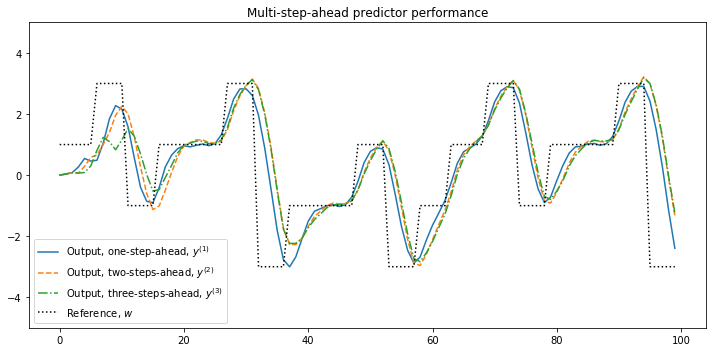

In [26]:
plt.title('Multi-step-ahead predictor performance')
plt.plot(y_l1[-N:], label=r"Output, one-step-ahead, $y^{(1)}$")
plt.plot(y_l2[-N:], label=r"Output, two-steps-ahead, $y^{(2)}$", linestyle='--')
plt.plot(y_l3[-N:], label=r"Output, three-steps-ahead, $y^{(3)}$", linestyle='-.')
plt.plot(w[:N], label=r"Reference, $w$", color='k', linestyle=':')
plt.ylim([-5,5])
plt.legend()
plt.tight_layout()
plt.savefig('MSPIPerformance.pdf')